# Training a model to predict FMA genre from features

**Problem:** We have features & genre of music tracks, but we don't know how to determine what songs are most similar to each other

**Hypothesis:** If two songs are predicted to belong to similar genres, they will be more similar

**Objective:** Use FMA features to get a vector of probabilities of the song belonging to each genre. Then use cosine similarity to get a score of "genre similarity": songs predicted to belong to similar genres will be similar

In [1]:
__import__('sys').path.append('../scripts/'); __import__('notebook_utils').table_of_contents('Feature_to_genre_model.ipynb')

<h3>Table of contents</h3>


[Training a model to predict FMA genre from features](#Training-a-model-to-predict-FMA-genre-from-features)
- [Setup](#Setup)
- [Reuse code from GitHub: GenrePredicter_DNN_Keras.py](#Reuse-code-from-GitHub:-GenrePredicter_DNN_Keras.py)
- [Train model: predict genres from features](#Train-model:-predict-genres-from-features)
- [Get similarity score: compute cosine similarity between each pair of songs](#Get-similarity-score:-compute-cosine-similarity-between-each-pair-of-songs)
- [Generate ranking tables for quick retrieval](#Generate-ranking-tables-for-quick-retrieval)

## Setup 

In [2]:
# IMPORTS
import re

from keras.layers import Input, Dense, Dropout
from keras.models import Model
from keras import backend as K
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import jaccard_score, accuracy_score, precision_score, recall_score, f1_score

2025-01-31 17:11:38.157034: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-31 17:11:38.158112: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-31 17:11:38.161973: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-31 17:11:38.173292: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1738343498.190076   13165 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738343498.19

In [3]:
# CLASSES
class paths():
    FMA_D = 'data/FMA/fma_metadata/' # path to the FMA metadata files

    FEATURE_D = FMA_D + 'features.csv' # features for each track
    TRACKS_D = FMA_D + 'tracks.csv' # metadata for every track. We only use the genre column
    GENRE_D = FMA_D + 'genres.csv' # genre key from ID to string

## Reuse code from GitHub: GenrePredicter_DNN_Keras.py
Copied [this github](https://github.com/MiningMyBusiness/ExploringFreeMusicArchiveDataset/blob/master/Code/GenrePredicter_DNN_Keras.py) code. It:
* Uses an autoencoder to reduce the dimensionality of your precomputed features.
* Trains a classifier on the reduced representation to predict genres.

Results from this GitHub after exploring the FMA are explained [here](https://github.com/MiningMyBusiness/ExploringFreeMusicArchiveDataset)

In [4]:
## LOAD IN AND PROCESS DATA

# define function to get numpy array of song features
# this keeps lots of variables with redundant data out of RAM
def getFeatures(featureDir):
    myFeatures = pd.read_csv(featureDir, low_memory=False) # load data
    featureMat = myFeatures.values # turn to np matrix
    onlyFeats = featureMat[3:,1:].astype(float) # extract just features w/o feature labels
    return onlyFeats

# define function to normalize features
def normalize_features(featureMat):
    dimMax = featureMat.max(0)
    dimMin = featureMat.min(0)
    dimRange = dimMax - dimMin
    normMat = featureMat - np.tile(dimMin, [featureMat.shape[0], 1]) # subtract mean from matrix
    normMat = np.divide(normMat, np.tile(dimRange, [featureMat.shape[0], 1])) # divide by standard deviation
    return normMat, dimMax, dimMin

# define function to get numpy array of song genre
def getGenre(tracksDir):
    myLabels = pd.read_csv(tracksDir, low_memory=False) # load data
    labelMat = myLabels.values # turn into np matrix
    topGenreIndx = np.where(labelMat[0,:] == 'genres_all') # find column with top genre info for songs
    songGenres = labelMat[2:,topGenreIndx[0][0]] # get song genres
    return songGenres

# define function to grab genre names
def getGenreNames(genreDir):
    genreNames = pd.read_csv(genreDir) # load in file with genre info
    genreMat = genreNames.values # extract values from the data frame
    allGenreName = genreMat[:,3] # get the names of genres
    allGenreIds = genreMat[:,0] # get all genre ids
    genreToIndx = {}
    idToGenre = {}
    indxToGenre = {}
    counter = 0
    for name,id in zip(allGenreName, allGenreIds):
        genreToIndx[name] = counter
        indxToGenre[counter] = name
        idToGenre[id] = name
        counter += 1
    return genreToIndx, idToGenre, indxToGenre

# create matrix of labels with genre IDs
# define function to create list of song genres
def extract_song_genre_names(genres,  num_of_genres, idToGenre, genreToIndx):
    thisSongLabels = np.zeros(num_of_genres)
    commaIndx = [m.start() for m in re.finditer(',', genres)] # find the position of commas
    if len(genres) == 2: # genre only has two brackets (no genre)
        thisSongLabels[-1] = 1
    if len(commaIndx) == 0 and len(genres) > 2: # no commas in the string and only one genre
        genreId = int(genres[1:-1]) # get genre ID as an integer
        genreName = idToGenre[genreId] # pull genre name from array
        thisSongLabels[genreToIndx[genreName]] = 1
    if len(commaIndx) > 0 and len(genres) > 2: # if a song has more than one genre (at least one comma in the string)
        for x in range(0,len(commaIndx) + 1): # go through each comma index and append genres ignoring starting and ending brackets
            if x == 0:
                oneGenreId = int(genres[1:commaIndx[x]])
            elif x > 0 and x < len(commaIndx):
                oneGenreId = int(genres[commaIndx[x-1]+1:commaIndx[x]])
            elif x == len(commaIndx):
                oneGenreId = int(genres[commaIndx[x-1]+1:-1])
            oneGenreName = idToGenre[oneGenreId]
            thisSongLabels[genreToIndx[oneGenreName]] = 1
    return thisSongLabels

# Get features of songs
print('Grabbing song features...')
onlyFeats = getFeatures(paths.FEATURE_D)
onlyFeats, dimMax, dimMin = normalize_features(onlyFeats)
num_of_features = onlyFeats.shape[1]

# Get the top genre for all songs
print('Grabbing song genres...')
songGenres = getGenre(paths.TRACKS_D)
num_of_songs = songGenres.shape[0]

# Get number of genres and genre names
print('Creating dictionaries for genre name and ID...')
genreToIndx, idToGenre, indxToGenre = getGenreNames(paths.GENRE_D)
num_of_genres = len(genreToIndx.keys()) + 1 # the total number of genres and plus 1 if a song has no genre listed

# go through each song and grab the genres
print('Create label matrix of song genres...')
genreLabels = np.zeros((num_of_songs, num_of_genres))
for i,genres in enumerate(songGenres):
    thisSongLabels = extract_song_genre_names(genres,  num_of_genres, idToGenre, genreToIndx)
    genreLabels[i,:] = thisSongLabels

Grabbing song features...
Grabbing song genres...
Creating dictionaries for genre name and ID...
Create label matrix of song genres...


In [5]:
## BUILD DEEP AUTOENCODER
print('Building autoencoder model...')

# encoded dimension
encoded_dim = 164

# number of classes
num_classes = num_of_genres

# input placeholder
input_img = Input(shape=(num_of_features,))
# 'encoder' model
encoded = Dense(512, activation='relu')(input_img)
encoded = Dense(512, activation='relu')(encoded)
encoded = Dense(256, activation='relu')(encoded)
encoded = Dense(encoded_dim, activation='relu')(encoded)

# 'decoder' model
decoded = Dense(256, activation='relu')(encoded)
decoded = Dense(512, activation='relu')(decoded)
decoded = Dense(512, activation='relu')(decoded)
decoded = Dense(num_of_features, activation='sigmoid')(decoded)

# create seperate encoder
encoder = Model(input_img, encoded)

# full autoeconder model
autoencoder = Model(input_img, decoded)

# configure model to be trained
# per-feature binary crossentropy loss
autoencoder.compile(optimizer='Adam', loss='binary_crossentropy')

Building autoencoder model...


2025-01-31 17:12:52.594135: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [6]:
## TRAIN THE AUTOENCODER MODEL
# TODO - Change epochs from 2 to 20 (here) & from 2 to 10 (in the next cell). I lowered it for testing purposes
print('Training autoencoder model...')

# shuffle array and labels
rng_state = np.random.get_state()
np.random.shuffle(onlyFeats)
np.random.set_state(rng_state)
np.random.shuffle(genreLabels)
propTest = 0.2
nTrain = int((1-propTest)*num_of_songs)

autoencoder.fit(onlyFeats[0:nTrain,:], onlyFeats[0:nTrain,:],
                epochs=10,
                batch_size=32,
                shuffle=True,
                validation_data=(onlyFeats[nTrain:,:], onlyFeats[nTrain:,:]))


Training autoencoder model...
Epoch 1/10
2665/2665 ━━━━━━━━━━━━━━━━━━━━ 55s 20ms/step - loss: 0.4666 - val_loss: 0.4573
Epoch 2/10
2665/2665 ━━━━━━━━━━━━━━━━━━━━ 52s 20ms/step - loss: 0.4571 - val_loss: 0.4563
Epoch 3/10
2665/2665 ━━━━━━━━━━━━━━━━━━━━ 54s 20ms/step - loss: 0.4560 - val_loss: 0.4557
Epoch 4/10
2665/2665 ━━━━━━━━━━━━━━━━━━━━ 55s 21ms/step - loss: 0.4556 - val_loss: 0.4555
Epoch 5/10
2665/2665 ━━━━━━━━━━━━━━━━━━━━ 52s 19ms/step - loss: 0.4554 - val_loss: 0.4553
Epoch 6/10
2665/2665 ━━━━━━━━━━━━━━━━━━━━ 54s 20ms/step - loss: 0.4552 - val_loss: 0.4555
Epoch 7/10
2665/2665 ━━━━━━━━━━━━━━━━━━━━ 49s 18ms/step - loss: 0.4551 - val_loss: 0.4552
Epoch 8/10
2665/2665 ━━━━━━━━━━━━━━━━━━━━ 49s 18ms/step - loss: 0.4550 - val_loss: 0.4550
Epoch 9/10
2665/2665 ━━━━━━━━━━━━━━━━━━━━ 48s 18ms/step - loss: 0.4547 - val_loss: 0.4548
Epoch 10/10
2665/2665 ━━━━━━━━━━━━━━━━━━━━ 48s 18ms/step - loss: 0.4548 - val_loss: 0.4548


In [7]:
##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
## Validate the info compression of autencoder model
##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
print('Validating autoencoder model...')

from sklearn.metrics import r2_score
y_pred = autoencoder.predict(onlyFeats[nTrain:,:])
varExpl = r2_score(onlyFeats[nTrain:,:], y_pred,
            multioutput='variance_weighted')
print('Proportion of variance explained: ' + str(varExpl))

##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
## Build classifier network with encoder on the bottom
##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
print('Building classifier model...')

x = encoder.output
# add a classification layer
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)
predictions = Dense(num_of_genres, activation='sigmoid')(x)

# this is the model we will train for classification
model = Model(encoder.input, predictions)

# first we need to freeze all encoder layers so they
# are not trained by the classification process
for layer in encoder.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer='Adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])

##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
## Train the classifier model
##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
print('Training classifier model...')

model.fit(onlyFeats[0:nTrain,:], genreLabels[0:nTrain,:],
                epochs=10,
                batch_size=32,
                shuffle=True,
                validation_data=(onlyFeats[nTrain:,:], genreLabels[nTrain:,:]))

Validating autoencoder model...
667/667 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
Proportion of variance explained: 0.8252953126847546
Building classifier model...
Training classifier model...
Epoch 1/10
2665/2665 ━━━━━━━━━━━━━━━━━━━━ 32s 12ms/step - accuracy: 0.2675 - loss: 0.0785 - val_accuracy: 0.3370 - val_loss: 0.0623
Epoch 2/10
2665/2665 ━━━━━━━━━━━━━━━━━━━━ 29s 11ms/step - accuracy: 0.3202 - loss: 0.0621 - val_accuracy: 0.3171 - val_loss: 0.0611
Epoch 3/10
2665/2665 ━━━━━━━━━━━━━━━━━━━━ 29s 11ms/step - accuracy: 0.3239 - loss: 0.0611 - val_accuracy: 0.3146 - val_loss: 0.0609
Epoch 4/10
2665/2665 ━━━━━━━━━━━━━━━━━━━━ 32s 12ms/step - accuracy: 0.3296 - loss: 0.0602 - val_accuracy: 0.3195 - val_loss: 0.0600
Epoch 5/10
2665/2665 ━━━━━━━━━━━━━━━━━━━━ 27s 10ms/step - accuracy: 0.3337 - loss: 0.0597 - val_accuracy: 0.3089 - val_loss: 0.0598
Epoch 6/10
2665/2665 ━━━━━━━━━━━━━━━━━━━━ 33s 12ms/step - accuracy: 0.3359 - loss: 0.0593 - val_accuracy: 0.3436 - val_loss: 0.0593
Epoch 7/10
2665/2665 ━━━

Validating classifier model...
667/667 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
Calculating accuracy, precision, and recall...


/home/cdt_wsl/wsl_courses/Melody-Match/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


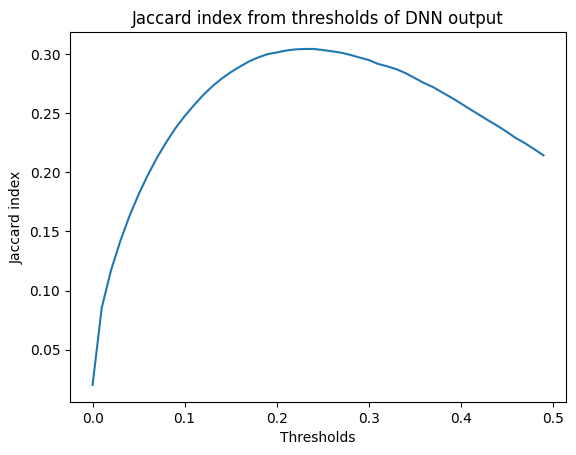

In [ ]:
##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
## Validate the classifier model
##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
print('Validating classifier model...')

label_pred = model.predict(onlyFeats[nTrain:,:])
threshs = np.arange(0, 0.5, 0.01)
jacIndxs = np.zeros(threshs.shape)
for i,thresh in enumerate(threshs):
    thisJacIndx = jaccard_score(genreLabels[nTrain:,:], label_pred > thresh, average='samples')
    jacIndxs[i] = thisJacIndx

plt.plot(threshs, jacIndxs)
plt.xlabel('Thresholds')
plt.ylabel('Jaccard index')
plt.title('Jaccard index from thresholds of DNN output')

##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
## Threshold predictions and calculate accuracy for each genre
##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
print('Calculating accuracy, precision, and recall...')

# calculate accuracy, precision, and recall
optThresh = threshs[np.argmax(jacIndxs)]
label_pred = label_pred > optThresh

# Calculate all metrics
genreAcc = accuracy_score(genreLabels[nTrain:, :], label_pred)
genrePres = precision_score(genreLabels[nTrain:, :], label_pred, average='samples')
genreRecall = recall_score(genreLabels[nTrain:, :], label_pred, average='samples')
genreF1 = f1_score(genreLabels[nTrain:, :], label_pred, average='samples')

In [13]:
# Per-genre metrics
genrePres = precision_score(genreLabels[nTrain:, :], label_pred, average=None)
genreRecall = recall_score(genreLabels[nTrain:, :], label_pred, average=None)
genreF1 = f1_score(genreLabels[nTrain:, :], label_pred, average=None)

# For accuracy per genre, you can calculate it manually
isCorrect = (label_pred == genreLabels[nTrain:, :])
genreAcc = np.sum(isCorrect, axis=0) / isCorrect.shape[0]

/home/cdt_wsl/wsl_courses/Melody-Match/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/cdt_wsl/wsl_courses/Melody-Match/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/cdt_wsl/wsl_courses/Melody-Match/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mod

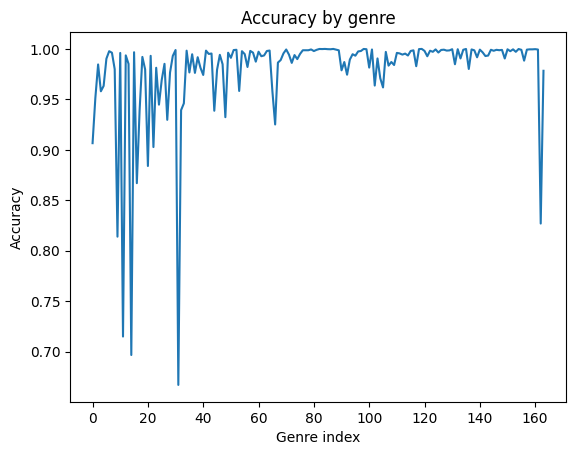

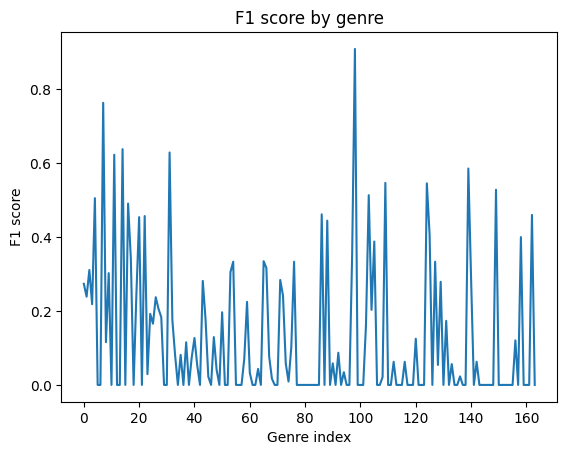

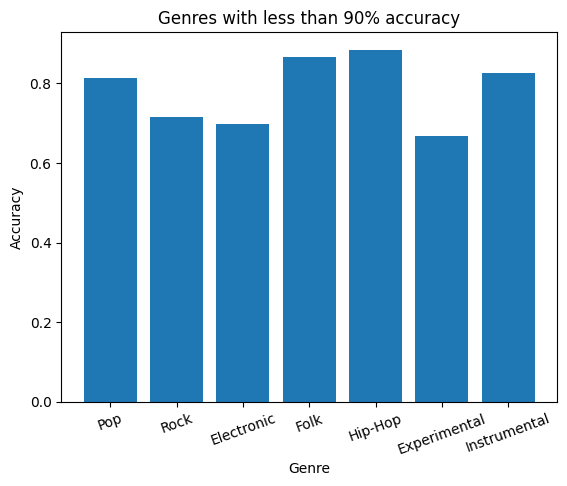

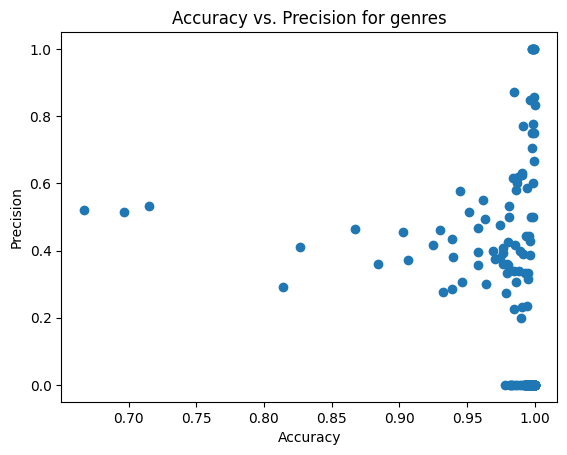

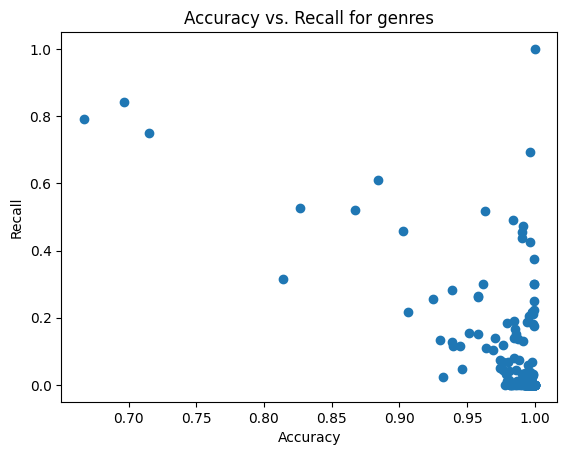

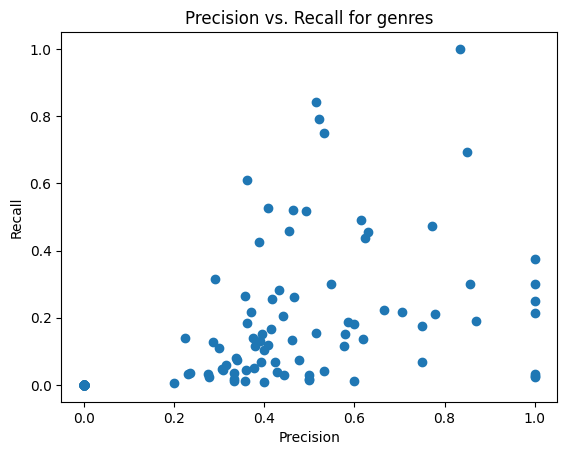

In [14]:
# PLOTS
# plot accuracy
plt.plot(genreAcc)
plt.xlabel('Genre index')
plt.ylabel('Accuracy')
plt.title('Accuracy by genre')
plt.show()

# plot F1 score
plt.plot(genreF1)
plt.xlabel('Genre index')
plt.ylabel('F1 score')
plt.title('F1 score by genre')
plt.show()

# get genres with less than 90% accuracy
accLess90 = np.where(genreAcc < 0.9)
less90List = []
less90Acc = []
for index in accLess90[0]:
    thisGenre = indxToGenre[index]
    less90List.append(thisGenre)
    less90Acc.append(genreAcc[index])
plt.bar(less90List, less90Acc)
plt.xlabel('Genre')
plt.ylabel('Accuracy')
plt.xticks(rotation=20)
plt.title('Genres with less than 90% accuracy')
plt.show()

# plot accuracy vs precision
plt.scatter(genreAcc, genrePres)
plt.xlabel('Accuracy')
plt.ylabel('Precision')
plt.title('Accuracy vs. Precision for genres')
plt.show()

# plot accuracy vs recall
plt.scatter(genreAcc, genreRecall)
plt.xlabel('Accuracy')
plt.ylabel('Recall')
plt.title('Accuracy vs. Recall for genres')
plt.show()

# plot precision vs recall
plt.scatter(genrePres, genreRecall)
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.title('Precision vs. Recall for genres')
plt.show()

## Train model: predict genres from features

## Get similarity score: compute cosine similarity between each pair of songs

## Generate ranking tables for quick retrieval